In [90]:
import soccerdata as sd
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm

In [91]:
df1 = pd.read_csv("FootballData_ENG-Premier League.csv")
df2 = pd.read_csv("FootballData_ITA-Serie A.csv")
df3 = pd.read_csv("FootballData_ESP-La Liga.csv")
df4 = pd.read_csv("FootballData_GER-Bundesliga.csv")
df5 = pd.read_csv("FootballData_FRA-Ligue 1.csv")
df = pd.concat([df1,df2,df3,df4,df5])
df
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date')

In [92]:
df.select_dtypes(["object"])

,Div,Time,HomeTeam,AwayTeam,FTR,HTR,Referee
8122,F1,NaN,Nantes,Monaco,H,NaN,NaN
8474,F1,NaN,Strasbourg,Auxerre,D,NaN,NaN
8467,F1,NaN,Bordeaux,Paris SG,H,NaN,NaN
8468,F1,NaN,Caen,Metz,D,NaN,NaN
8469,F1,NaN,Lille,Martigues,D,NaN,NaN
...,...,...,...,...,...,...,...
3480,E0,14:00,West Ham,Burnley,D,A,D England
2725,D1,14:30,Bochum,Freiburg,A,A,NaN
3817,E0,20:00,Chelsea,Newcastle,H,D,J Brooks
3535,I1,19:45,Lazio,Udinese,A,D,NaN


In [93]:
df = df.drop(["Unnamed: 0.1","Div","Time","Referee"], axis=1)

In [94]:
# Dropearemos todas las columnas que tienen menos del 50% de los datos
porcentaje_minimo = 0.5 * len(df)
df = df.dropna(axis=1, thresh=int(porcentaje_minimo))
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,IWA,WHH,WHD,WHA,VCH,VCD,VCA,LBH,LBD,LBA
8122,1993-07-23,Nantes,Monaco,1.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8474,1993-07-24,Strasbourg,Auxerre,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8467,1993-07-24,Bordeaux,Paris SG,1.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8468,1993-07-24,Caen,Metz,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8469,1993-07-24,Lille,Martigues,1.0,1.0,D,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480,2024-03-10,West Ham,Burnley,2.0,2.0,D,0.0,2.0,A,22.0,...,NaN,1.65,4.0,4.80,1.62,3.9,5.00,NaN,NaN,NaN
2725,2024-03-10,Bochum,Freiburg,1.0,2.0,A,0.0,1.0,A,18.0,...,NaN,2.25,3.6,3.00,2.20,3.6,3.10,NaN,NaN,NaN
3817,2024-03-11,Chelsea,Newcastle,3.0,2.0,H,1.0,1.0,D,12.0,...,NaN,1.85,4.2,3.50,1.90,3.8,3.50,NaN,NaN,NaN
3535,2024-03-11,Lazio,Udinese,1.0,2.0,A,0.0,0.0,D,18.0,...,NaN,1.91,3.5,4.00,1.83,3.1,4.33,NaN,NaN,NaN


In [95]:
df_ceros = df.fillna(-1)

for columna in df_ceros.columns:
    if columna not in df.select_dtypes(["object"]).keys():
        nombre_columna_indicadora = columna + '_presente'
        df[nombre_columna_indicadora] = df_ceros[columna].apply(lambda x: 1 if x != -1 else 0)
df = df.fillna(0)

In [8]:
def encontrar_min_feature(row):
    max_value = row.min()
    max_features = row[row == max_value].index.tolist()  # Obtener todas las características con el valor máximo
    if len(max_features) == 1:
        return max_features[0]  # Si solo hay una característica con el valor máximo, retornar su nombre
    else:
        return 'D'  # Si hay un empate, retornar 'Draw'

# Crear una nueva columna con la característica que tiene el valor máximo, manejando empates
df["B365"] = df[['B365H', 'B365D', 'B365A']].apply(encontrar_min_feature, axis=1)
df["BW"] = df[['BWH', 'BWD', 'BWA']].apply(encontrar_min_feature, axis=1)
df["IW"] = df[['IWH', 'IWD', 'IWA']].apply(encontrar_min_feature, axis=1)
df["WH"] = df[['WHH', 'WHD', 'WHA']].apply(encontrar_min_feature, axis=1)
df["VC"] = df[['VCH', 'VCD', 'VCA']].apply(encontrar_min_feature, axis=1)
df["LB"] = df[['LBH', 'LBD', 'LBA']].apply(encontrar_min_feature, axis=1)

In [9]:
def comparacion_resultado(row):
    if row[0] == 0:
        return -1
    Resultado = row[1][-1]
    if Resultado == row[2]:
        return 1
    else:
        return 0
    

df["B365_correcto"] = df[["B365H_presente","B365","FTR"]].apply(comparacion_resultado, axis=1)
df["BW_correcto"] = df[["BWH_presente","BW","FTR"]].apply(comparacion_resultado, axis=1)
df["IW_correcto"] = df[["IWH_presente","IW","FTR"]].apply(comparacion_resultado, axis=1)
df["WH_correcto"] = df[["WHH_presente","WH","FTR"]].apply(comparacion_resultado, axis=1)
df["VC_correcto"] = df[["VCH_presente","VC","FTR"]].apply(comparacion_resultado, axis=1)
df["LB_correcto"] = df[["LBH_presente","LB","FTR"]].apply(comparacion_resultado, axis=1)

C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] == 0:
C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Resultado = row[1][-1]
C:\Users\gfuen\AppData\Local\Temp\ipykernel_20948\2159620430.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if Resultado == row[2]:
C:\Users\gfuen\AppData\Local\Temp\

In [10]:
# Estadísticas
B365 = sum(df["B365_correcto"]==1) / sum(df["B365_correcto"]>=0)
BW = sum(df["BW_correcto"]==1) / sum(df["BW_correcto"]>=0)
IW = sum(df["IW_correcto"]==1) / sum(df["IW_correcto"]>=0)
WH = sum(df["WH_correcto"]==1) / sum(df["WH_correcto"]>=0)
VC = sum(df["VC_correcto"]==1) / sum(df["VC_correcto"]>=0)
LB = sum(df["LB_correcto"]==1) / sum(df["LB_correcto"]>=0)

print(f"B365 predichos :{B365}")
print(f"BW predichos :{BW}")
print(f"IW predichos :{IW}")
print(f"WH predichos :{WH}")
print(f"VC predichos :{VC}")
print(f"LB predichos :{LB}")

B365 predichos :0.5294209417821576
BW predichos :0.5294564056439373
IW predichos :0.5252283022067195
WH predichos :0.5281647339119442
VC predichos :0.5323482663213045
LB predichos :0.524517280545189


In [11]:
df = df.drop(['"B365"_correcto', 'BW_correcto', 'IW_correcto', 'WH_correcto', 'VC_correcto', 'LB_correcto',
              "B365","BW","IW","WH","VC","LB"],axis = 1)

# Modelo 1: Solo tasas de apuestas

In [35]:
casas = ["B365","BW","IW","WH","VC","LB"]
col = []
for i in range(len(casas)):
    col.append(casas[i]+"H")
    col.append(casas[i]+"D")
    col.append(casas[i]+"A")
    col.append(casas[i]+"H_presente")
    col.append(casas[i]+"D_presente")
    col.append(casas[i]+"A_presente")

In [47]:
X = df.get(col)
y = df['FTR']

y = y[X.T.sum()>0]
X = X[X.T.sum()>0] # Trabajamos solo si hay datos, los datos nulos van a hacer mal al modelo.

y = pd.get_dummies(y,dtype=int)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
X_train

,B365H,B365D,B365A,B365H_presente,B365D_presente,B365A_presente,BWH,BWD,BWA,BWH_presente,...,VCA,VCH_presente,VCD_presente,VCA_presente,LBH,LBD,LBA,LBH_presente,LBD_presente,LBA_presente
1989,5.00,3.75,1.67,1,1,1,4.60,3.75,1.70,1,...,1.67,1,1,1,5.00,3.75,1.670,1,1,1
3370,5.00,3.40,1.61,1,1,1,0.00,0.00,0.00,0,...,0.00,0,0,0,4.50,3.25,1.667,1,1,1
2044,2.00,3.00,3.40,1,1,1,0.00,0.00,0.00,0,...,0.00,0,0,0,2.00,3.00,3.400,1,1,1
9044,1.44,4.33,7.50,1,1,1,1.44,4.20,7.25,1,...,7.00,1,1,1,1.44,4.33,7.000,1,1,1
7713,1.55,4.33,5.50,1,1,1,1.57,4.20,5.50,1,...,6.00,1,1,1,0.00,0.00,0.000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,4.20,3.30,1.91,1,1,1,3.90,3.30,1.95,1,...,1.91,1,1,1,3.75,3.20,1.830,1,1,1
9170,1.57,4.00,5.75,1,1,1,1.62,4.00,5.50,1,...,5.50,1,1,1,1.62,3.80,5.500,1,1,1
6232,5.75,3.80,1.70,1,1,1,5.25,3.60,1.72,1,...,1.75,1,1,1,5.50,3.60,1.730,1,1,1
7909,0.00,0.00,0.00,0,0,0,0.00,0.00,0.00,0,...,0.00,0,0,0,0.00,0.00,0.000,0,0,0


In [58]:
y_train

,A,D,H
1989,0,1,0
3370,0,0,1
2044,1,0,0
9044,0,1,0
7713,0,1,0
...,...,...,...
10272,1,0,0
9170,0,1,0
6232,1,0,0
7909,1,0,0


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


drop = 0.0
size_layer = 32
batch_size = 64
epoch = 10
model = Sequential([
    Dense(size_layer, activation='relu',
          input_shape=(X.shape[1],), use_bias=True,),
    Dense(32, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(y.shape[1], activation='softmax', use_bias=True,)
])
# # Compilamos el modelo
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
# adam = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.99, beta_2=0.9999)

# hinge = tf.keras.losses.CategoricalHinge()
# focal_cross = tf.keras.losses.CategoricalFocalCrossentropy(
#     alpha=0.2, gamma=2, from_logits=False, label_smoothing=0.0)
# cross = tf.keras.losses.CategoricalCrossentropy(
#     from_logits=False, label_smoothing=0.0)

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=epoch, batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/10


c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5021 - loss: 1.0030 - val_categorical_accuracy: 0.5235 - val_loss: 0.9847
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5254 - loss: 0.9865 - val_categorical_accuracy: 0.5191 - val_loss: 0.9875
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5257 - loss: 0.9827 - val_categorical_accuracy: 0.5213 - val_loss: 0.9847
Epoch 4/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5286 - loss: 0.9803 - val_categorical_accuracy: 0.5232 - val_loss: 0.9822
Epoch 5/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5254 - loss: 0.9823 - val_categorical_accuracy: 0.5251 - val_loss: 0.9823
Epoch 6/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.5289 - loss: 0.9784 - val_categorical_accuracy: 0.5244 - val_loss: 0.9829
Epoch 7/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.5261 - loss: 0.9821 -

1047/1047 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step


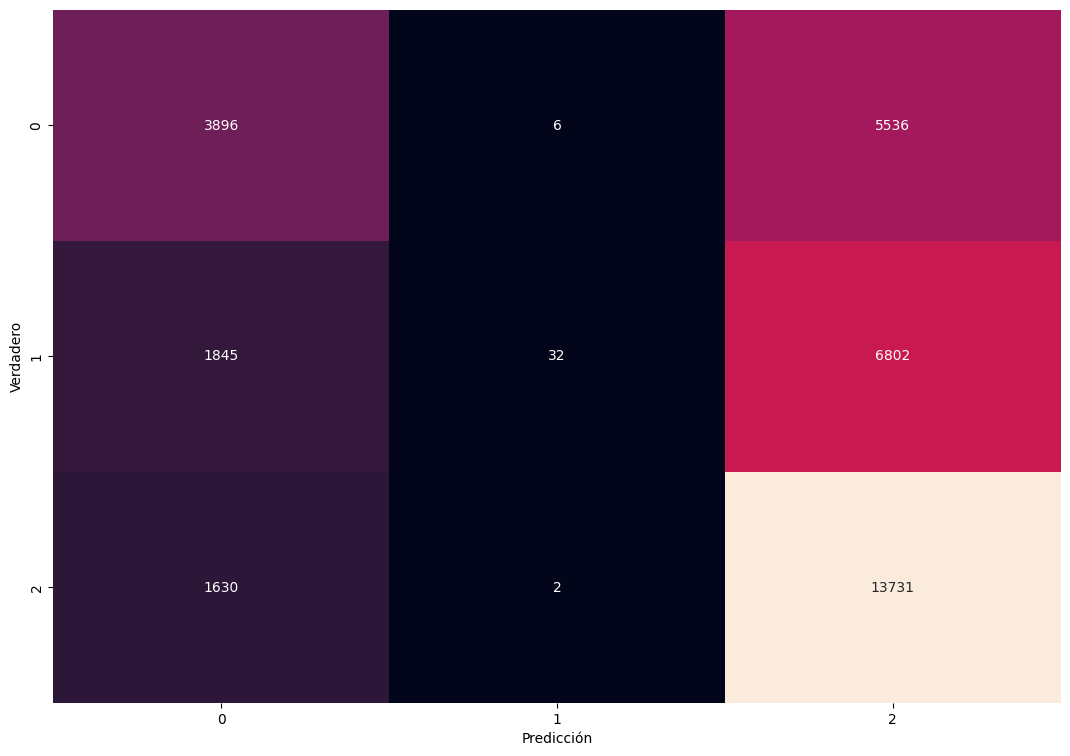

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'])


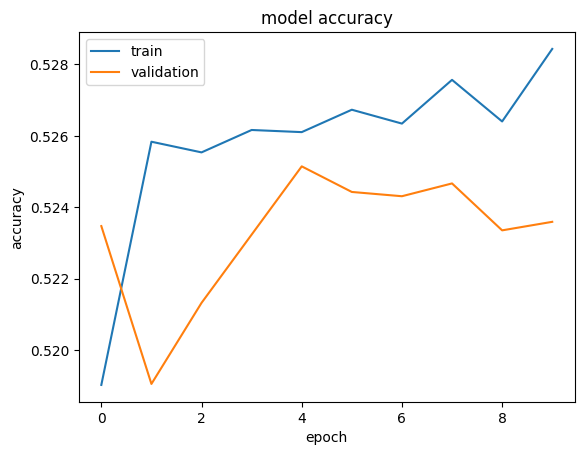

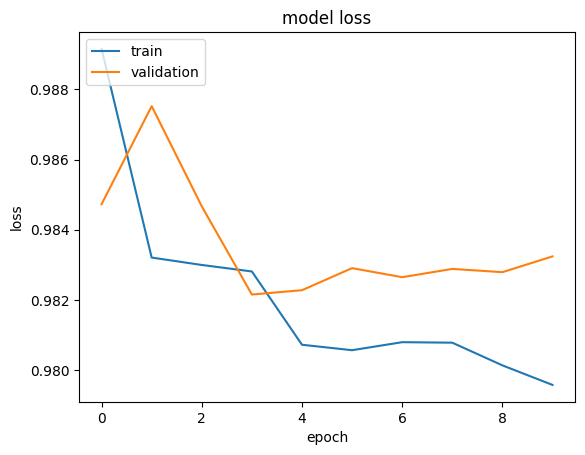

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from copy import deepcopy

y_prob = model.predict(X_train)
y_test_metrics = np.argmax(y_train, axis=1)
y_pred = np.argmax(y_prob, axis=1)

y_pred_copy = deepcopy(y_pred)
y_test_metrics_copy = deepcopy(y_test_metrics)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
plt.figure(figsize=(13, 9))

sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Modelo 2: Empezar a usar datos de apuestas pasados

In [108]:
casas = ["B365","BW","IW","WH","VC","LB"]
features = []
for i in range(len(casas)):
    features.append(casas[i]+"H")
    features.append(casas[i]+"D")
    features.append(casas[i]+"A")
    features.append(casas[i]+"H_presente")
    features.append(casas[i]+"D_presente")
    features.append(casas[i]+"A_presente")

In [121]:
def get_features(data, features):
    return pd.DataFrame(data[features])


def search_apuestas(i, df, last_games, features):
    team_home = df.iloc[i]["HomeTeam"]
    team_away = df.iloc[i]["AwayTeam"]
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match_home1 = df[df["HomeTeam"] == team_home]
    df_match_home2 = df[df["AwayTeam"] == team_home]
    df_match_away1 = df[df["HomeTeam"] == team_away]
    df_match_away2 = df[df["AwayTeam"] == team_away]

    merged_df_home = pd.concat([df_match_home1, df_match_home2])
    merged_df_home.drop_duplicates(inplace=True)
    merged_df_home = merged_df_home.sort_values(by="Date", ascending=False)

    merged_df_away = pd.concat([df_match_away1, df_match_away2])
    merged_df_away.drop_duplicates(inplace=True)
    merged_df_away = merged_df_away.sort_values(by="Date", ascending=False)

    # El index 0 es el partido, por lo que iteramos desde el 1
    data_home = pd.DataFrame()
    data_away = pd.DataFrame()

    for j in range(1, last_games + 1):
        if team_home == merged_df_home.iloc[j]["HomeTeam"]:
            d = get_features(merged_df_home.iloc[j],features)
            d["played_home"] = 1
            d["played_away"] = 0
            data_home = pd.concat([data_home, d.T])
        elif team_home == merged_df_home.iloc[j]["AwayTeam"]:
            d = get_features(merged_df_home.iloc[j],features)
            d["played_home"] = 0
            d["played_away"] = 1
            data_home = pd.concat([data_home, d])
        print(data_home)


prueba = search_apuestas(i, df, 5, features)


                 399  played_home  played_away
B365H            4.2            0            1
B365D            3.6            0            1
B365A           1.85            0            1
B365H_presente     1            0            1
B365D_presente     1            0            1
B365A_presente     1            0            1
BWH              4.1            0            1
BWD              3.6            0            1
BWA             1.87            0            1
BWH_presente       1            0            1
BWD_presente       1            0            1
BWA_presente       1            0            1
IWH              0.0            0            1
IWD              0.0            0            1
IWA              0.0            0            1
IWH_presente       0            0            1
IWD_presente       0            0            1
IWA_presente       0            0            1
WHH              4.0            0            1
WHD             3.75            0            1
WHA          

In [105]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,IWA_presente,WHH_presente,WHD_presente,WHA_presente,VCH_presente,VCD_presente,VCA_presente,LBH_presente,LBD_presente,LBA_presente
8122,1993-07-23,Nantes,Monaco,1.0,0.0,H,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8474,1993-07-24,Strasbourg,Auxerre,1.0,1.0,D,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8467,1993-07-24,Bordeaux,Paris SG,1.0,0.0,H,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8468,1993-07-24,Caen,Metz,1.0,1.0,D,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
8469,1993-07-24,Lille,Martigues,1.0,1.0,D,0.0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480,2024-03-10,West Ham,Burnley,2.0,2.0,D,0.0,2.0,A,22.0,...,0,1,1,1,1,1,1,0,0,0
2725,2024-03-10,Bochum,Freiburg,1.0,2.0,A,0.0,1.0,A,18.0,...,0,1,1,1,1,1,1,0,0,0
3817,2024-03-11,Chelsea,Newcastle,3.0,2.0,H,1.0,1.0,D,12.0,...,0,1,1,1,1,1,1,0,0,0
3535,2024-03-11,Lazio,Udinese,1.0,2.0,A,0.0,0.0,D,18.0,...,0,1,1,1,1,1,1,0,0,0
